# Tutorial 1: The Perceptron & The XOR Problem

**Course:** CSEN 342: Deep Learning  
**Topic:** Linear Classifiers, The Need for Hidden Layers, and Manual Backpropagation

## Objective
In this tutorial, we will explore the foundational concepts of neural networks by implementing them from scratch using **NumPy**. We will:
1.  Implement the **Perceptron** algorithm and demonstrate its failure on the **XOR** problem.
2.  Build a **Multi-Layer Perceptron (MLP)** from scratch using NumPy matrices.
3.  Manually implement **Forward Propagation** and **Backpropagation** to solve XOR.

This "under the hood" implementation will help you understand exactly what deep learning frameworks like PyTorch do for you automatically.

---

## Part 1: The Perceptron Limitations (Recap)

We start by implementing a simple Perceptron to verify it works on linearly separable data (AND gate) but fails on non-linear data (XOR gate).

**The Update Rule:**
$$ \theta^{[k+1]} = \theta^{[k]} + \lambda (y^{(i)} - h_{\theta^{[k]}}(x^{(i)})) x^{(i)} $$

Final Errors: 4


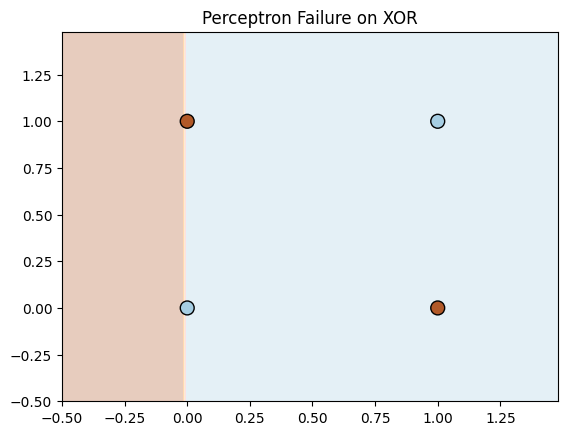

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class SimplePerceptron:
    def __init__(self, input_size, lr=0.1, epochs=20):
        self.lr = lr
        self.epochs = epochs
        self.weights = np.zeros(input_size + 1) # +1 for bias

    def predict(self, x):
        z = self.weights[0] + np.dot(x, self.weights[1:])
        return 1 if z >= 0 else 0

    def train(self, X, y):
        self.errors_ = []
        for _ in range(self.epochs):
            errors = 0
            for xi, target in zip(X, y):
                update = self.lr * (target - self.predict(xi))
                self.weights[1:] += update * xi
                self.weights[0] += update
                errors += int(update != 0.0)
            self.errors_.append(errors)
        return self

# Visualization Utility
def plot_decision_boundary(X, y, classifier, title):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    Z = np.array([classifier.predict(np.array([x, y_val])) for x, y_val in np.c_[xx.ravel(), yy.ravel()]])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=100, cmap=plt.cm.Paired)
    plt.title(title)
    plt.show()

# 1. Define XOR Data
X_xor = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y_xor = np.array([0, 1, 1, 0])

# 2. Train Perceptron
ppn = SimplePerceptron(input_size=2, lr=0.1, epochs=20)
ppn.train(X_xor, y_xor)

# 3. Visual Proof of Failure
print(f"Final Errors: {ppn.errors_[-1]}")
plot_decision_boundary(X_xor, y_xor, ppn, "Perceptron Failure on XOR")

---

## Part 2: The Multi-Layer Perceptron (NumPy Implementation)

To solve XOR, we need a hidden layer to transform the inputs into a linearly separable space. We will implement a network with the following architecture:

1.  **Input Layer:** 2 Neurons ($x_1, x_2$)
2.  **Hidden Layer:** 4 Neurons (Sigmoid Activation)
3.  **Output Layer:** 1 Neuron (Sigmoid Activation)

We will manually calculate the gradients for backpropagation.

### 2.1 Activation Functions
We need a non-linear activation function. We will use the **Sigmoid** function:
$$ \sigma(z) = \frac{1}{1 + e^{-z}} $$

For backpropagation, we also need its derivative:
$$ \sigma'(z) = \sigma(z) \cdot (1 - \sigma(z)) $$

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(output):
    # output is already sigmoid(z)
    return output * (1 - output)

### 2.2 The Manual MLP Class
Here we implement the full training cycle:
1.  **Init:** Random weights for Input->Hidden ($W1$) and Hidden->Output ($W2$).
2.  **Forward:** Compute activations layer by layer.
3.  **Backward:** Calculate error, compute deltas using the Chain Rule, and update weights.

In [3]:
class NumpyMLP:
    def __init__(self, input_size, hidden_size, output_size, lr=0.1):
        self.lr = lr
        
        # Initialize Weights (Input -> Hidden)
        # Shape: (2 inputs, 4 hidden)
        self.W1 = np.random.uniform(-1, 1, (input_size, hidden_size))
        self.b1 = np.zeros((1, hidden_size))
        
        # Initialize Weights (Hidden -> Output)
        # Shape: (4 hidden, 1 output)
        self.W2 = np.random.uniform(-1, 1, (hidden_size, output_size))
        self.b2 = np.zeros((1, output_size))

    def forward(self, X):
        # 1. Input -> Hidden
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sigmoid(self.z1)
        
        # 2. Hidden -> Output
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = sigmoid(self.z2)
        return self.a2

    def train(self, X, y, epochs=10000):
        self.losses = []
        y = y.reshape(-1, 1) # Ensure target is column vector
        
        for _ in range(epochs):
            # --- Forward Pass ---
            output = self.forward(X)
            
            # --- Backward Pass (Backpropagation) ---
            # 1. Output Layer Error
            # Error = (Target - Output)
            error_output = y - output
            
            # Delta Output = Error * Derivative(Activation)
            delta_output = error_output * sigmoid_derivative(output)
            
            # 2. Hidden Layer Error
            # Propagate delta backwards: delta_output * W2_transpose
            error_hidden = delta_output.dot(self.W2.T)
            
            # Delta Hidden = Error_Hidden * Derivative(Activation)
            delta_hidden = error_hidden * sigmoid_derivative(self.a1)
            
            # --- Weight Updates (Gradient Descent) ---
            # Update W2: Hidden_Output.T dot Delta_Output
            self.W2 += self.a1.T.dot(delta_output) * self.lr
            self.b2 += np.sum(delta_output, axis=0, keepdims=True) * self.lr
            
            # Update W1: Input.T dot Delta_Hidden
            self.W1 += X.T.dot(delta_hidden) * self.lr
            self.b1 += np.sum(delta_hidden, axis=0, keepdims=True) * self.lr
            
            # Track Mean Squared Error
            loss = np.mean(np.square(error_output))
            self.losses.append(loss)

    def predict(self, x):
        # Helper for the plotting function (thresholds probability at 0.5)
        # Ensure input is 2D array
        if x.ndim == 1:
            x = x.reshape(1, -1)
        return 1 if self.forward(x) > 0.5 else 0

### 2.3 Training on XOR
Now we train our manual NumPy network. We use 4 hidden neurons and run for 10,000 epochs to ensure convergence.

Final Predictions:
[[0.03 ]
 [0.955]
 [0.958]
 [0.053]]


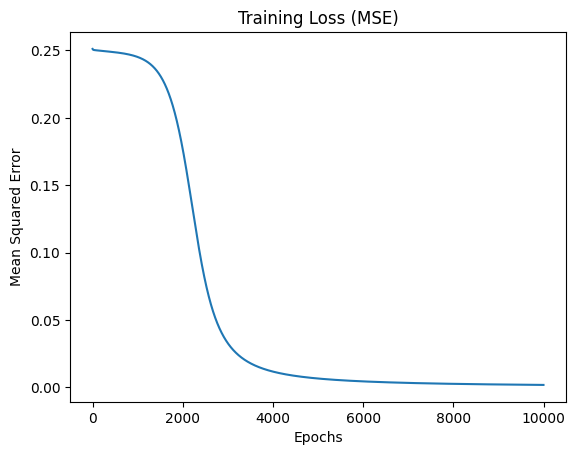

In [4]:
# Initialize Model: 2 Inputs -> 4 Hidden -> 1 Output
mlp = NumpyMLP(input_size=2, hidden_size=4, output_size=1, lr=0.1)

# Train
mlp.train(X_xor, y_xor, epochs=10000)

# Check Results
print("Final Predictions:")
print(mlp.forward(X_xor).round(3))

# Plot Loss Curve
plt.plot(mlp.losses)
plt.title("Training Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error")
plt.show()

### 2.4 Visualizing the Solution
Because we introduced a hidden layer, the network can now learn a non-linear boundary.

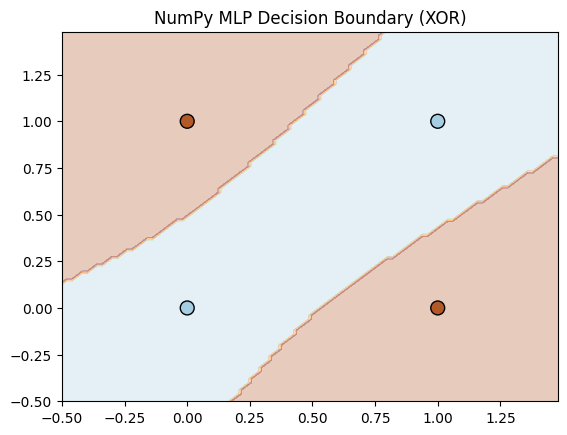

In [5]:
plot_decision_boundary(X_xor, y_xor, mlp, "NumPy MLP Decision Boundary (XOR)")

**Success!** The manually implemented Multi-Layer Perceptron has successfully separated the XOR classes. The hidden layer mapped the inputs to a space where the output layer could draw a line separating them.

In the next tutorial, we will see how **PyTorch** automates all of this (forward pass, backward pass, and updates) so we don't have to write matrix math manually.